# Feature Engineering

## Video 3 : Feature Transformation 

In [4]:
#import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [5]:
#read train, validation and test data
df_train = pd.read_csv('train_feature.csv')
df_test = pd.read_csv('test_feature.csv')
df_val = pd.read_csv('validation_feature.csv')

In [6]:
df_train.head()

,SKU_ID,Date,Page_traffic,Revenue($),Unit_price,Units_sold,Segment,1_Star_Rating,2_Star_Rating,3_Star_Rating,...,Sum of Spend,Online_Clicks,Online_Cost,Online_Impressions,num_unique_campaigns,Clicks_video,Cost_video,Impressions_video,num_unique_campaigns_offline,Units_sold>1000
0,SKU732,13-08-2022,3260.0,37006,24.703605,1498,Makeup,82,64,180,...,0.000000,0,0.000000,0,0,0,0.0,0,0,1
1,SKU1506,12-06-2021,3729.0,25316,22.226514,1139,Makeup,31,15,41,...,0.000000,0,0.000000,0,0,0,0.0,0,0,1
2,SKU840,29-10-2022,2675.0,32454,25.574468,1269,Makeup,19,14,37,...,0.000000,0,0.000000,0,0,0,0.0,0,0,1
3,SKU1387,19-03-2022,6281.0,36238,20.971065,1728,Makeup,25,18,62,...,408.036474,917,2654.489552,133688,4,5744,63978.2,6594469,2,1
4,SKU1183,23-01-2021,131.0,0,20.099526,0,Skincare,23,21,45,...,0.000000,0,0.000000,0,0,0,0.0,0,0,0


### Feature Transformation - Transforming Categorical Variables

In [7]:
#one-hot encoding of the categorical variable
df_train = pd.get_dummies(df_train, columns = ['Segment'], prefix = 'Segment', drop_first = True)
df_val = pd.get_dummies(df_val, columns = ['Segment'], prefix = 'Segment', drop_first = True)
df_test = pd.get_dummies(df_test, columns = ['Segment'], prefix = 'Segment', drop_first = True)

In [8]:
#create a function that can check model performance everytime we do some feature engineering
def check_model_performance(df_train, df_val, model=None):
    if model is None:
        model = GradientBoostingClassifier(max_depth=9, min_samples_leaf=30,
    n_estimators=50, random_state=42)
        
    x_train = df_train.drop(['SKU_ID', 'Date', 'Revenue($)', 
                         'Units_sold', 'Units_sold>1000'], axis=1)
    y_train = df_train['Units_sold>1000']

    x_val = df_val.drop(['SKU_ID', 'Date', 'Revenue($)', 
                             'Units_sold', 'Units_sold>1000'], axis=1)
    y_val = df_val['Units_sold>1000']

    model.fit(x_train, y_train)
    
    train_score = f1_score(y_train, model.predict(x_train))
    val_score = f1_score(y_val, model.predict(x_val))
    
    print(f"Performance on Train Data: {train_score}")
    print(f"Performance on Validation Data: {val_score}")

In [9]:
check_model_performance(df_train, df_val)

Performance on Train Data: 0.9376331360946746
Performance on Validation Data: 0.8914073768802803


### Mathematical Transformation -  Outlier Treatment

Here we've created a function called __handle_train_outliers__ for our dataset.

This function will showcase boxplots for all the numerical features and clip the features with outliers to have a minimum value 1.5 times IQR below the 25th percentile and a maximum value of 1.5 times IQR above the 75th percentile.

In [10]:
# create a function to handle outliers
def handle_train_outliers(data, col_name):
    #calculate the iqr
    perc_25, perc_75 = np.percentile(data[col_name], [25, 75])
    iqr = perc_75 - perc_25
    
    #check whether the column has outliers
    outlier_checker = lambda x: (x > (perc_75 + 1.5 * iqr)) \
        or (x < (perc_25 - 1.5 * iqr))
    
    is_outlier = data[col_name].apply(outlier_checker)
    
    #visulaize the outliers
    plt.figure(figsize=(5, 5))
    
    sns.boxplot(data=data, x=col_name)
    plt.title(f"Box Plot for {col_name}, Outlier Count: {sum(is_outlier)}")
    
    plt.show()
    plt.close()
    
    return perc_25, perc_75, data[col_name].clip(lower=perc_25 - 1.5 * iqr, 
                               upper=perc_75 + 1.5 * iqr).values

Since test and valid data represent future data here, we will clip the outliers with the 25th and the 75th percentile values of the train dataset. The logic is, to never use information from validation and test set to make changes in them since they represent unseen datasets.

In [11]:
# Handle outliers in test dataset
#input will have predefined values of 25th percentile and 75th percentile from the train data
def handle_outliers(data, col_name, perc_25, per_75):
    iqr = perc_75 - perc_25

    return data[col_name].clip(lower=perc_25 - 1.5 * iqr, 
                               upper=perc_75 + 1.5 * iqr).values

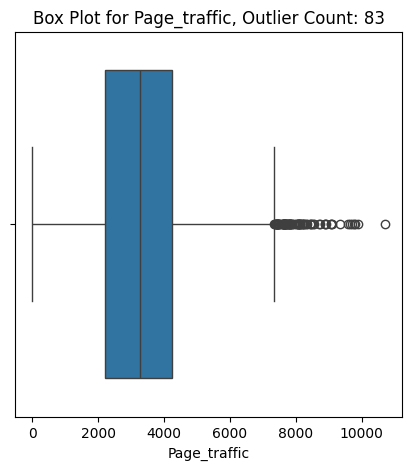

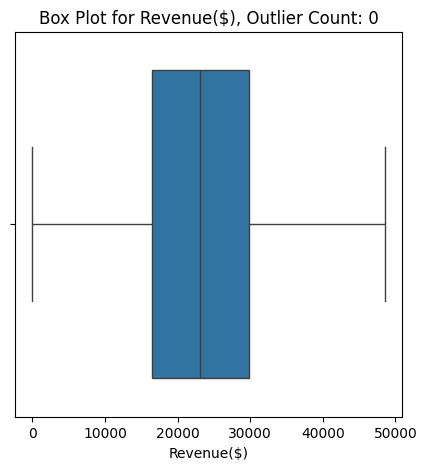

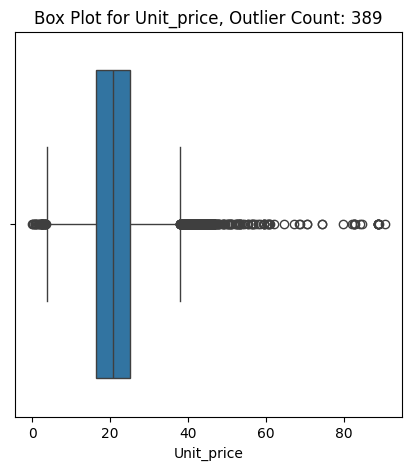

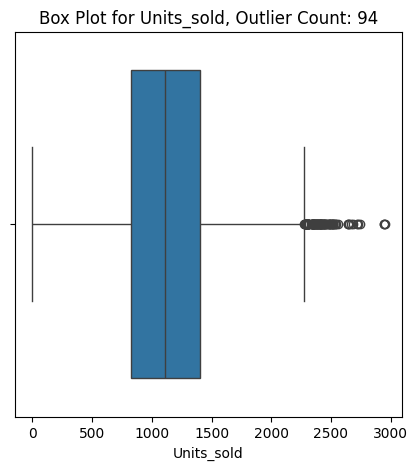

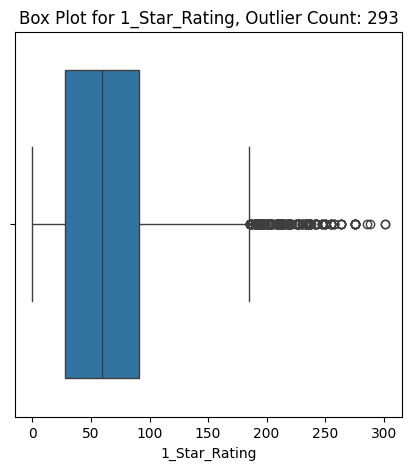

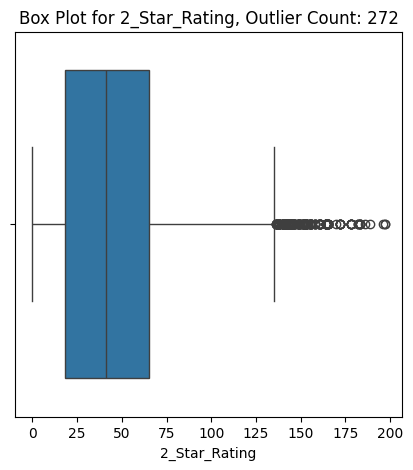

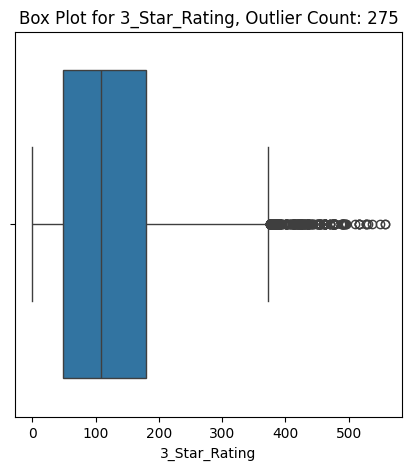

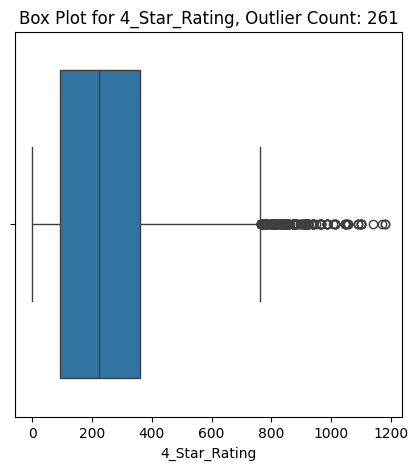

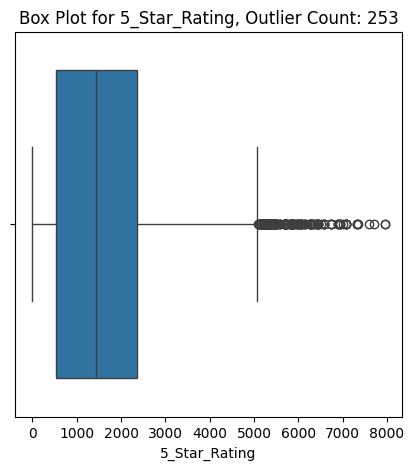

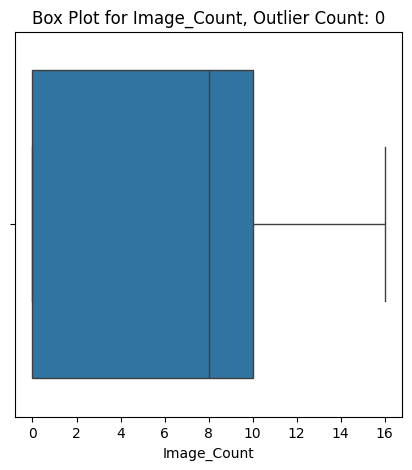

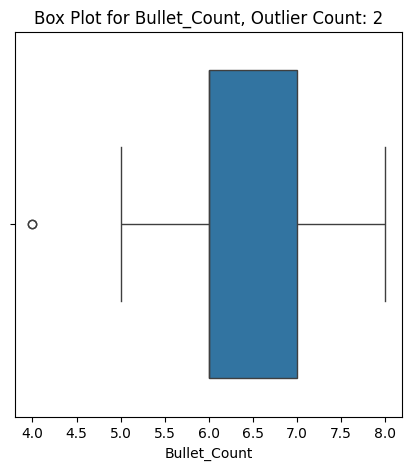

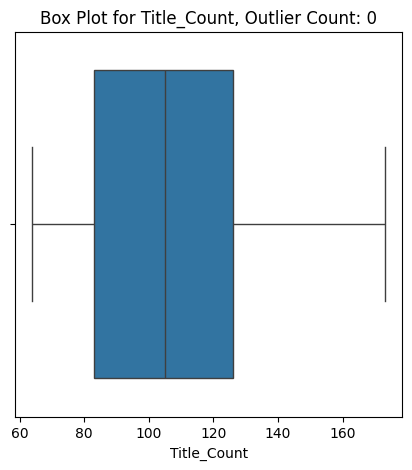

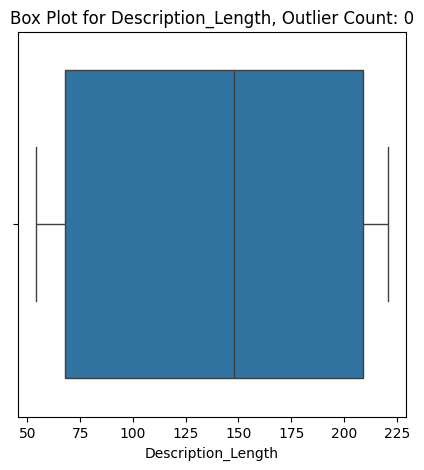

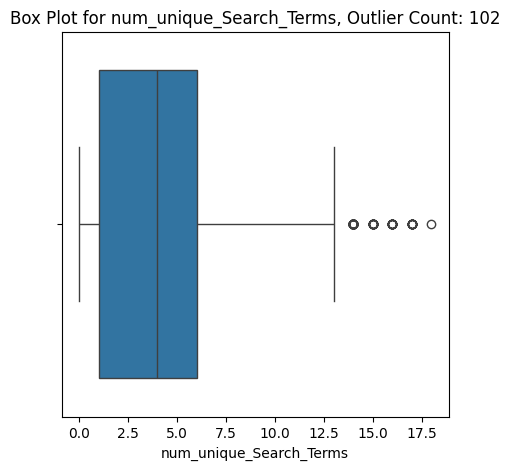

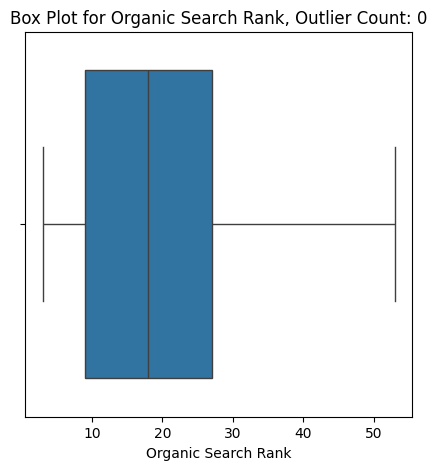

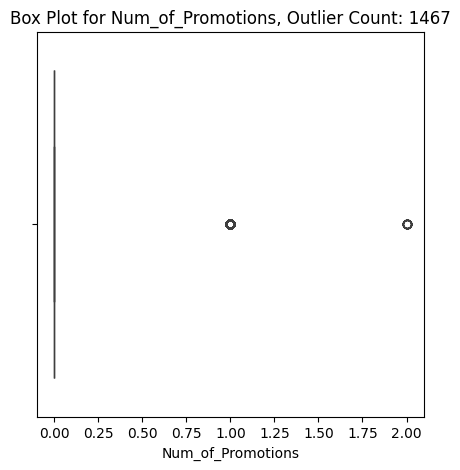

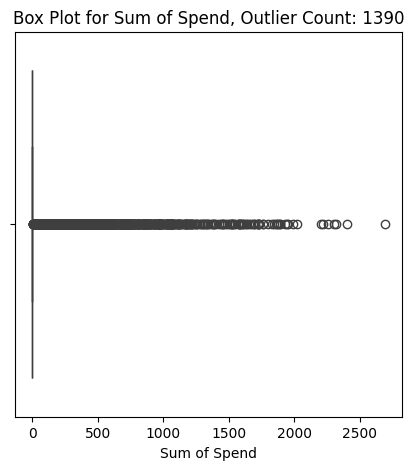

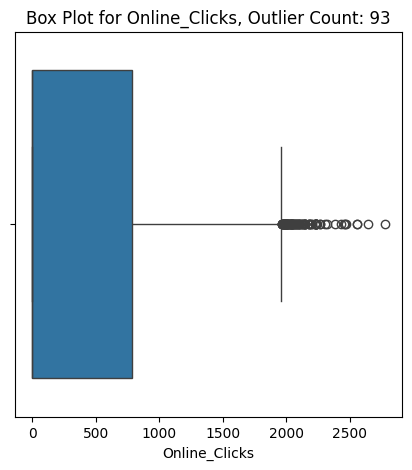

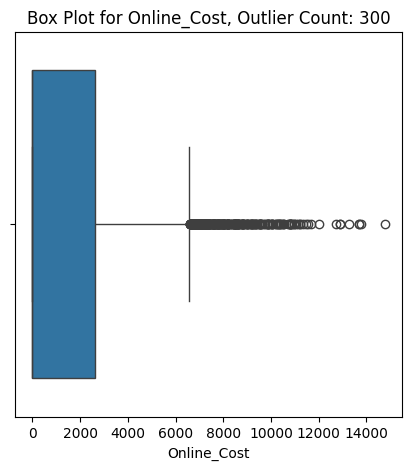

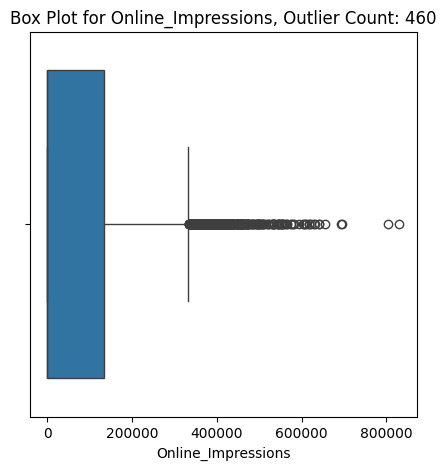

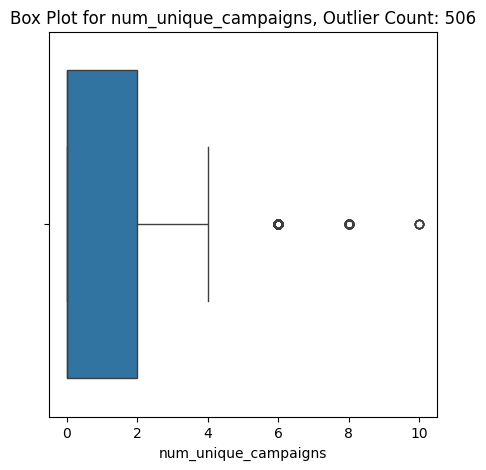

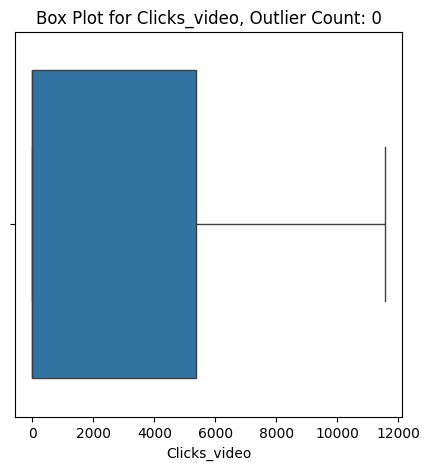

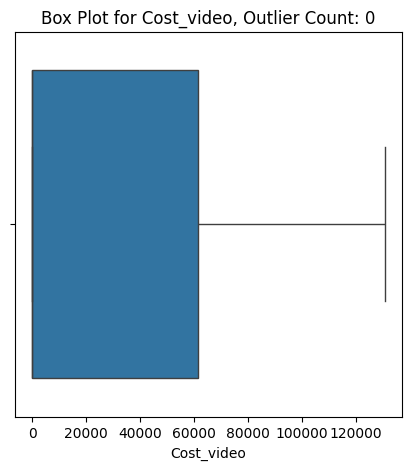

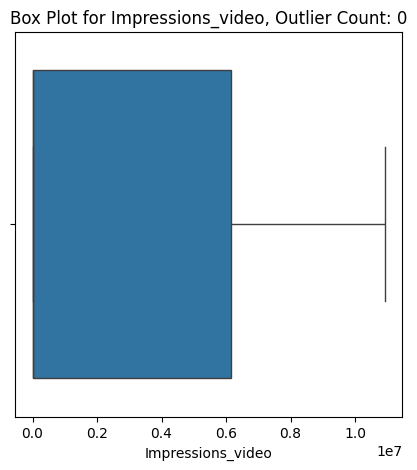

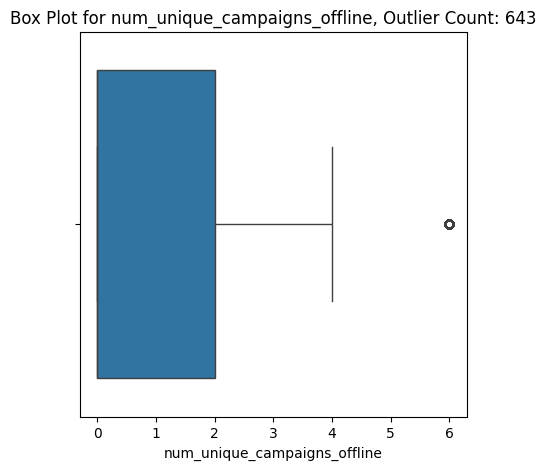

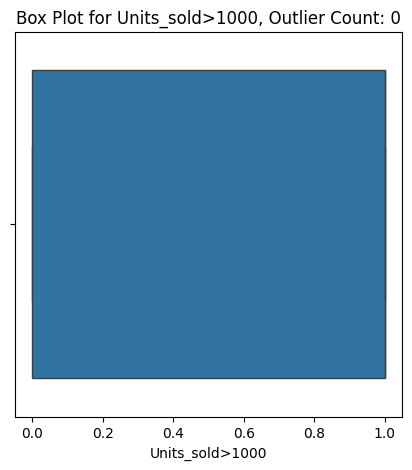

In [12]:
# iterate over each column in the training data
for col in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[col]) and not pd.api.types.is_bool_dtype(df_train[col]):
        perc_25, perc_75, df_train[col] = handle_train_outliers(df_train, col)
        df_test[col] = handle_outliers(df_test, col, perc_25, perc_75)
        df_val[col] = handle_outliers(df_val, col, perc_25, perc_75)

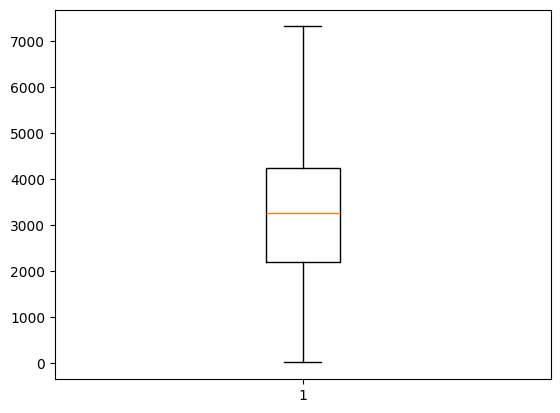

In [13]:
# Create the boxplot
plt.boxplot(df_train["Page_traffic"])

# Show the plot
plt.show()

In [14]:
check_model_performance(df_train, df_val)

Performance on Train Data: 0.9408206831119544
Performance on Validation Data: 0.8935995060712081


Well this change is negligible. The major reason for this is that Gradient Boosting models are tree based models and they do not get affected by the outliers.

#### Why did we not scale the data?

And if you are wondering, why we have not scaled the data as a part of feature trandormation, we have a reason. Since we are using a tree based model, scaling data is not necessary. These models make decisions based on the order and relationships between features, not their exact values. So, whether your features are in different units or scales doesn't matter.

And with that, we have covered feature transformation. In the upcoming video we will focus on feature generation. See you there. 

## Video 4 : Feature Generation

<p style = 'color:green'><b>Run all the cells above before you begin</b><p>

### 1. Ratings Column

In [15]:
#Select all columns from df_train that contain the string 'Star_Rating'
rating_cols = df_train.columns[df_train.columns.str.contains('Star_Rating')]

In [16]:
rating_cols

Index(['1_Star_Rating', '2_Star_Rating', '3_Star_Rating', '4_Star_Rating',
       '5_Star_Rating'],
      dtype='object')

In [17]:
average_rating_calc = lambda x : np.round(sum([i * val for i, val in enumerate(x, start=1)]) /\
                                          (sum(x) + 1E-15), 1)

#### Explanation

Suppose you have a dataset where each row represents a product and columns represent the count of 1-star, 2-star, 3-star, 4-star, and 5-star ratings that product has received.

Here's an example row of such data:

        1-star: 2
        2-star: 3
        3-star: 4
        4-star: 5
        5-star: 6
        
Now, let's multiply the count of ratings with their rating weights.

__Multiplying each rating by its occurrence:__

        1-star: 1×2=2
        2-star: 2×3=6
        3-star: 3×4=12
        4-star: 4×5=20
        5-star: 5×6=30
    
__Summing these products:__

Total = 2+6+12+20+30=70

__Calculating the total number of ratings:__

Total ratings = 2+3+4+5+6=20

__Computing the weighted average:__

Average = 70/20 = 3.5

Same calculation for average rating is done in synergix dataset.

In [18]:
df_train['average_rating'] = df_train[rating_cols].apply(average_rating_calc, 
                                                     axis=1)
df_val['average_rating'] = df_val[rating_cols].apply(average_rating_calc, 
                                                     axis=1)
df_test['average_rating'] = df_test[rating_cols].apply(average_rating_calc, 
                                                     axis=1)

In [19]:
df_train.average_rating.describe()

count    13741.000000
mean         3.908733
std          1.548162
min          0.000000
25%          4.500000
50%          4.600000
75%          4.600000
max          4.900000
Name: average_rating, dtype: float64

In [20]:
check_model_performance(df_train, df_val)

Performance on Train Data: 0.9408347166231918
Performance on Validation Data: 0.8933443571723853


### 2. Online Cost Per Impression

In [21]:
df_train['online_cost_per_impression'] = df_train['Online_Cost'] / (df_train['Online_Impressions'] + 1)
df_test['online_cost_per_impression'] = df_test['Online_Cost'] / (df_test['Online_Impressions'] + 1)
df_val['online_cost_per_impression'] = df_val['Online_Cost'] / (df_val['Online_Impressions'] + 1)

### 3. Video Cost Per Impression

In [22]:
df_train['video_cost_per_impression'] = df_train['Cost_video'] / (df_train['Impressions_video'] + 1)
df_test['video_cost_per_impression'] = df_test['Cost_video'] / (df_test['Impressions_video'] + 1)
df_val['video_cost_per_impression'] = df_val['Cost_video'] / (df_val['Impressions_video'] + 1)

### 4. Total Cost 

In [23]:
df_train['total_cost'] = df_train['Online_Cost'] + df_train['Cost_video']
df_val['total_cost'] = df_val['Online_Cost'] + df_val['Cost_video']
df_test['total_cost'] = df_test['Online_Cost'] + df_test['Cost_video']

In [24]:
check_model_performance(df_train, df_val)

Performance on Train Data: 0.9390323538141881
Performance on Validation Data: 0.8937834499794154


Feature engineering is kind of a trial and error method and you cannot spend all the time in creating and deleting each new variable having an adverse impact on the model. We will delete all the irrelevant variables when we do feature selection later. For now, let's keep on creating new features.

### 5. Total Clicks 

In [25]:
df_train['total_clicks'] = df_train['Online_Clicks'] + df_train['Clicks_video']
df_val['total_clicks'] = df_val['Online_Clicks'] + df_val['Clicks_video']
df_test['total_clicks'] = df_test['Online_Clicks'] + df_test['Clicks_video']

### 6. Feature Engineering with Dates


In [26]:
df_train['Date'].head()

0    13-08-2022
1    12-06-2021
2    29-10-2022
3    19-03-2022
4    23-01-2021
Name: Date, dtype: object

In [27]:
#Convert 'Date' column from string format to datetime objects.
df_train['Date'] = pd.to_datetime(df_train.Date, format="%d-%m-%Y")
df_test['Date'] = pd.to_datetime(df_test.Date, format="%d-%m-%Y")
df_val['Date'] = pd.to_datetime(df_val.Date, format="%d-%m-%Y")

In [28]:
df_train['month'] = df_train.Date.dt.month
df_test['month'] = df_test.Date.dt.month
df_val['month'] = df_val.Date.dt.month

In [29]:
df_train['is_month_end'] = df_train.Date.dt.is_month_end * 1
df_test['is_month_end'] = df_test.Date.dt.is_month_end * 1
df_val['is_month_end'] = df_val.Date.dt.is_month_end * 1

In [30]:
check_model_performance(df_train, df_val)

Performance on Train Data: 0.9484425986354198
Performance on Validation Data: 0.8973934629706247


One thing to note here is that feature generation is a step with too many possibilities. We have ourselves generated 7 new features till now. Why don't you try to create some other features? Here are some ideas-

- Spend per Promotion = ['Sum of Spend'] / ['Num_of_Promotions']
- Online cost to Total cost ratio'] = ['Online_Cost'] / ['total_cost']
- Video cost to total cost ratio = ['Cost_video'] / ['total_cost']
- Online clicks to total click ratio = ['Online_Clicks'] / ['total_clicks']

You can also create some illogical features without any hypothesis. For eg-
- Description per Image = ['Description_Length'] / ['Image_Count']

### Drop Irrelevant Columns and Split data into x and y

In [31]:
x_train = df_train.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_train = df_train['Units_sold>1000']

x_test = df_test.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_test = df_test['Units_sold>1000']

x_val = df_val.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_val = df_val['Units_sold>1000']

In [32]:
#create the final model
model_feature_eng = GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50, random_state=42)

model_feature_eng.fit(x_train, y_train)

#Making predictions for training data
y_pred_train = model_feature_eng.predict(x_train)

#Making predictions for validation data
y_pred_val = model_feature_eng.predict(x_val)

f1_train = f1_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)

print("F1 Score on training data:", f1_train)
print("F1 Score on validation data:", f1_val)

F1 Score on training data: 0.9484425986354198
F1 Score on validation data: 0.8973934629706247


This last step was just a cleaning exercise to prepare our dataset for our next video, which is feature selection. See you there.

## Video 5 : Feature Selection

<p style = 'color:green'><b>Run all the cells above before you begin</b><p>

### Forward Selection

In [33]:
#create new version of the data
x_train_fs = df_train.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_train_fs = df_train['Units_sold>1000']

x_test_fs = df_test.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_test_fs = df_test['Units_sold>1000']

x_val_fs = df_val.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_val_fs = df_val['Units_sold>1000']

In [34]:
#import relevant libraries
from sklearn.feature_selection import SequentialFeatureSelector

In [35]:
#create the model constructor
model_feature_eng = GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50, random_state=42)

__Rule__ - if the mean f1 score of a model does not increase by 0.005 after adding a new feature, we will not select that feature. Let us run this cell.

In [36]:
forward_selection = SequentialFeatureSelector(model_feature_eng, n_features_to_select ='auto', tol=0.005, 
                                              direction='forward', scoring='f1', 
                                              cv=3, n_jobs=-1)

In [37]:
#fit the model
forward_selection.fit(x_train_fs, y_train_fs)

SequentialFeatureSelector(cv=3,
                          estimator=GradientBoostingClassifier(max_depth=9,
                                                               min_samples_leaf=30,
                                                               n_estimators=50,
                                                               random_state=42),
                          n_jobs=-1, scoring='f1', tol=0.005)

In [38]:
#get the masekd names of the selected columns
selected_fs_mask = forward_selection.get_support()
#get the exact name of the selected columns
selected_fs_names = x_train_fs.columns[selected_fs_mask]

print("Selected Features:")
print(selected_fs_names)

Selected Features:
Index(['Page_traffic', 'Unit_price', '4_Star_Rating', 'Title_Count',
       'Description_Length', 'month'],
      dtype='object')


In [39]:
#modify the dataframe
x_train_fs = df_train.loc[:, selected_fs_names]
y_train_fs = df_train['Units_sold>1000']

x_test_fs = df_test.loc[:, selected_fs_names]
y_test_fs = df_test['Units_sold>1000']

x_val_fs = df_val.loc[:, selected_fs_names]
y_val_fs = df_val['Units_sold>1000']

In [40]:
#get model performance
model_feature_eng.fit(x_train_fs, y_train_fs)

y_pred_train_fs = model_feature_eng.predict(x_train_fs)
y_pred_val_fs = model_feature_eng.predict(x_val_fs)

f1_train_new = f1_score(y_train_fs, y_pred_train_fs)
f1_val_new = f1_score(y_val_fs, y_pred_val_fs)

print("F1 Score on training data:", f1_train_new)
print("F1 Score on validation data:", f1_val_new)

F1 Score on training data: 0.917706319920342
F1 Score on validation data: 0.8842450317557877


### Backward Selection

In [41]:
# creating a different version of dataset
x_train_bs = df_train.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_train_bs = df_train['Units_sold>1000']

x_test_bs = df_test.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_test_bs = df_test['Units_sold>1000']

x_val_bs = df_val.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_val_bs = df_val['Units_sold>1000']

In [42]:
backward_selection = SequentialFeatureSelector(model_feature_eng, n_features_to_select ='auto', 
                                               tol= -0.005, direction='backward', scoring='f1', cv=3, 
                                               n_jobs=-1)

In [43]:
backward_selection.fit(x_train_bs, y_train_bs)

SequentialFeatureSelector(cv=3, direction='backward',
                          estimator=GradientBoostingClassifier(max_depth=9,
                                                               min_samples_leaf=30,
                                                               n_estimators=50,
                                                               random_state=42),
                          n_jobs=-1, scoring='f1', tol=-0.005)

In [44]:
#get the masekd names of the selected columns
selected_bs_mask = backward_selection.get_support()
selected_bs_names = x_train_bs.columns[selected_bs_mask]

print("Selected Features from Forward Selection:")
print(selected_fs_names)

print("\nSelected Features from Backward Selection:")
print(selected_bs_names)

Selected Features from Forward Selection:
Index(['Page_traffic', 'Unit_price', '4_Star_Rating', 'Title_Count',
       'Description_Length', 'month'],
      dtype='object')

Selected Features from Backward Selection:
Index(['Page_traffic', 'Unit_price', '3_Star_Rating', 'Title_Count',
       'Description_Length', 'video_cost_per_impression', 'month'],
      dtype='object')


In [45]:
#modify the dataframe
x_train_bs = df_train.loc[:, selected_bs_names]
y_train_bs = df_train['Units_sold>1000']

x_test_bs = df_test.loc[:, selected_bs_names]
y_test_bs = df_test['Units_sold>1000']

x_val_bs = df_val.loc[:, selected_bs_names]
y_val_bs = df_val['Units_sold>1000']

In [46]:
# get the score afte backward selection
model_feature_eng.fit(x_train_bs, y_train_bs)

y_pred_train_bs = model_feature_eng.predict(x_train_bs)
y_pred_val_bs = model_feature_eng.predict(x_val_bs)

f1_train_new = f1_score(y_train_bs, y_pred_train_bs)
f1_val_new = f1_score(y_val_bs, y_pred_val_bs)

print("F1 Score on training data:", f1_train_new)
print("F1 Score on validation data:", f1_val_new)

F1 Score on training data: 0.923755217212392
F1 Score on validation data: 0.8877049180327868


### Embedded Method Tree - Based Model

In [47]:
# create a new version of the data
x_train_em = df_train.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_train_em = df_train['Units_sold>1000']

x_test_em = df_test.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_test_em = df_test['Units_sold>1000']

x_val_em = df_val.drop(['SKU_ID', 'Date', 'Revenue($)', 'Units_sold', 'Units_sold>1000'], axis=1)
y_val_em = df_val['Units_sold>1000']

In [48]:
model_feature_eng = GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50, random_state=42)

In [49]:
model_feature_eng.fit(x_train_em, y_train_em)

GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50,
                           random_state=42)

In [50]:
feature_importance = pd.DataFrame({
    'Feature': x_train_em.columns,
    'Importance': model_feature_eng.feature_importances_
})

In [51]:
#Sorting the dataframe
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)

feature_importance['cumulative'] = feature_importance.Importance.cumsum()
feature_importance

,Feature,Importance,cumulative
0,Page_traffic,0.357968,0.357968
1,Unit_price,0.128083,0.486051
9,Title_Count,0.069989,0.556041
10,Description_Length,0.057292,0.613333
7,Image_Count,0.051036,0.664368
30,month,0.042945,0.707314
2,1_Star_Rating,0.036903,0.744217
3,2_Star_Rating,0.024421,0.768638
4,3_Star_Rating,0.023062,0.791701
6,5_Star_Rating,0.020573,0.812274


In [52]:
# get the selected features
selected_features = feature_importance[:-9].Feature.tolist()
selected_features

['Page_traffic',
 'Unit_price',
 'Title_Count',
 'Description_Length',
 'Image_Count',
 'month',
 '1_Star_Rating',
 '2_Star_Rating',
 '3_Star_Rating',
 '5_Star_Rating',
 'Organic Search Rank',
 'online_cost_per_impression',
 '4_Star_Rating',
 'average_rating',
 'num_unique_Search_Terms',
 'total_clicks',
 'num_unique_campaigns',
 'total_cost',
 'Online_Impressions',
 'Segment_Makeup',
 'Online_Clicks',
 'Online_Cost',
 'video_cost_per_impression']

In [53]:
# Create a dataframe with separate independent and dependent variable
x_train = df_train.loc[:, selected_features]
y_train = df_train['Units_sold>1000']

x_test = df_test.loc[:, selected_features]
y_test = df_test['Units_sold>1000']

x_val = df_val.loc[:, selected_features]
y_val = df_val['Units_sold>1000']

In [54]:
model_feature_eng.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=9, min_samples_leaf=30, n_estimators=50,
                           random_state=42)

After training, the trained model is used to make predictions on the training and validation data with selected features.

In [55]:
y_pred_train = model_feature_eng.predict(x_train)
y_pred_val = model_feature_eng.predict(x_val)

f1_train_new = f1_score(y_train, y_pred_train)
f1_val_new = f1_score(y_val, y_pred_val)

print("F1 Score on training data:", f1_train_new)
print("F1 Score on validation data:", f1_val_new)

F1 Score on training data: 0.9458625192924136
F1 Score on validation data: 0.8964374482187241


In [56]:
# Combine train data
train_new = pd.concat([x_train, y_train], axis=1)

In [57]:
# Combine test data
test_new = pd.concat([x_test, y_test], axis=1)

In [58]:
# Combine validation data
val_new = pd.concat([x_val, y_val], axis=1)

In [59]:
# Export to CSV
train_new.to_csv('train_new.csv', index=False)
test_new.to_csv('test_new.csv', index=False)
val_new.to_csv('val_new.csv', index=False)

# Hyperparameter Tuning



## Video 8 : Grid Search

<p style = 'color:green'><b>Run all the cells above before you begin</b><p>

First, we will import GridSearchCV class from model_selection module present in sklearn liberary.

Hello learners!! So far we had theoritical understanding of hyperparameter tuning and its techniques. In this video, let us explore the first technique of Hyperparameter tuning - grid search.

One thing you need to keep in mind while creating models is that, in reak world-
- Either you choose overfit models, that give the best performance score on test data, or 
- We can choose a model that is good fit. Here the model will be performing a little lower on train data as compared to its performance on overfit model but will be closer to the performance on the test data.

Just like what we did in the previous course, we will set our goal to find the model that gives us the highest score on test data. Our model is already overfitting. So we can further increase the score on train data to get the best 

We have been using GradientBoostClassifier to make our prediction. This is a tree based model and they are known for overfitting.

We have been using 3 hyperparameters - n_estimators, max_depth and min_leaf_sample. But this time instead of min_sample leaves, we will be using learning_rate as it can help us achieve our goal of getting an overfit model.

- n-estimator controls the number of decision trees which will be built in sequence in a boosted ensemble model. So, increaing the nummber of estimators will lead to better performance of model, but a very high number will lead to overfitting. Since our goal is to increase the performance of the model on test data, we will check the performance of the model across a list of values - [50, 100, 200, 300, 400].

- Now max_depth is used to set the depth of the tree. Higher the number, more the model learns from training data and hence, overfitting. Since our model was overfitting at the end of feature engineering  at a max_depth of 9. Let us set the range between 2 to 9 with a gap of 2.

- The learning_rate ontrols the speed at which the model learns from the data. It essentially determines the size of the steps that the algorithm takes when updating the weights of the model during the training process. A higher value of learning_rate can lead to overfit models.

After understanding the logic behind the hyperparameters used. Let's begin with the first technique of hyperparamter - grid search.

In [60]:
from sklearn.model_selection import GridSearchCV

Then, we set the parameter grid with the values discussed above.

In [61]:
param_grid = {
    'n_estimators': [50, 100, 200, 300, 400],
    'max_depth': range(6, 13, 2),
    'learning_rate': [0.1, 0.2, 0.3]
}

Then let's create an instance model_GBC that saves the GradientBoostingClassifier with it's default values.

In [62]:
model_GBC = GradientBoostingClassifier()

Now, comes the step where we create the grid_search_cv instance which contains all the details or rules relevant for creation of the multiple models.

We have selected the gradient descent instance to be our estimator and the parameter grid has been defined above.  
Note that it is standard practice to perform use cross validation for data division hyperparameter tuning. And since we want to use all available cores on your machine for parallel computation, we set n-jobs = -1. Also, we will be performing 5-fold cross validation which is a standard practice when it comes to hyperparameter tuning. And finally, we have set f1 score as the scoring parameter. Let us run this cell.

In [63]:
grid_search_cv = GridSearchCV(estimator=model_GBC, param_grid=param_grid, n_jobs=-1, verbose=1,
                      cv=5, scoring='f1')

Now, let us fit this instance to our training data. Note that, this may take some time as we are building 60 models and each model is an average of 5 models since we are using cross validation. For context, it took us 20 minutes to execute this code.

In [64]:
grid_search_cv.fit(x_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': range(6, 13, 2),
                         'n_estimators': [50, 100, 200, 300, 400]},
             scoring='f1', verbose=1)

Now, let us get the best values hyperparameter values and the best cross validation score.

In [65]:
# Best performing model
grid_search_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.3, max_depth=10, n_estimators=400)

We can see that for max_depth and n_estimators, we are getting a values at the extreme ends of their respective ranges. This suggests that there might be better performing hyperparameters outside the current range you have explored. This situation often indicates that the search space is not adequately covering the optimal hyperparameter values. For now, we are continuing with these values. You can experiment with further values by changing the in the parameter grid we defined above.

In [66]:
# Mean cross-validated F1 score of the best estimator
grid_search_cv.best_score_

np.float64(0.9098153815448133)

We can see that the cross validation score on the test data is almost a percent higher than what we got at the end of feature selection in the last lesson. Now let us create an instance grid_search_best_model which is a gradient boosting classification model constructor and contains the parameter values from the best_estimator.

In [67]:
grid_search_best_model = GradientBoostingClassifier(n_estimators=400, max_depth=10,
                                    learning_rate=0.3, 
                                    random_state=42)

Now we fit the data on both train data and then predict and find the score on both train and validation data.

In [68]:
grid_search_best_model.fit(x_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, max_depth=10, n_estimators=400,
                           random_state=42)

In [69]:
#predict the dependent values
y_train_grid_search_pred = grid_search_best_model.predict(x_train)
y_val_grid_search_pred = grid_search_best_model.predict(x_val)

Finally, let us print the codes for both train and test data.

In [70]:
f1_train_grid_search = f1_score(y_train, y_train_grid_search_pred)
f1_val_grid_search = f1_score(y_val, y_val_grid_search_pred)

print("F1 Score on Train data:", f1_train_grid_search)
print("F1 Score on Val data:", f1_val_grid_search)

F1 Score on Train data: 1.0
F1 Score on Val data: 0.9197994987468672


And as we can see, we have an extremely overfitting model, with a perfect score of 1 on training data and a 91.06% score on the validation data which is our highest.

And with that we come to the end of this video where we have successfully implemented grid search cv. Without much manual trial and error, we were easily able to generate a higher performing model using grid search, But it comes with its own advantages and disadvantages. Let us discuss this in the next video.

## Video 9 - RandomizedSearchCV
<p style = 'color:green'><b>Run all the cells above before you begin</b><p>


The single most hyperparameter ehixh does the pruning most efficiently is max_depth, where we restrict the number of levels for the decision/split to be made. Lower the number, less is the chance of overfitting. Ideally decision trees should not exceed the maximum depth of 5 as it not only makes the decision tree complex  but it also hampers the interpretability. Ofcourse the chances of overfitting will increase.

The entire process remains the same as we did in gridsearch. So we will move through this quickly.

Let us begin with importing the relevant library.

In [71]:
from sklearn.model_selection import RandomizedSearchCV

Then we set the instance for random cv containing all the details or rules relevant for creation of the multiple models. The only difference here being we have an additional rule which says we will only iterate through any 10 random combinations of hyperparameters.

Unlike GridSearchCV, which exhaustively tries all possible combinations of the specified hyperparameters, RandomizedSearchCV randomly selects combinations. This can be significantly faster, especially when the hyperparameter space is large and only a limited number of iterations are needed to find a good combination.

In [72]:
random_cv = RandomizedSearchCV(estimator=model_GBC, n_iter=10, 
                               param_distributions=param_grid, n_jobs=-1, 
                               verbose=1, 
                               cv=5, scoring='f1')

Now we fit the model, find the best score and the estimator.

In [73]:
random_cv.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.2, 0.3],
                                        'max_depth': range(6, 13, 2),
                                        'n_estimators': [50, 100, 200, 300,
                                                         400]},
                   scoring='f1', verbose=1)

In [74]:
#best model estimator as per random search
random_cv.best_estimator_

GradientBoostingClassifier(learning_rate=0.2, max_depth=12, n_estimators=400)

In [75]:
#cross validation score for the best model after random search
random_cv.best_score_

np.float64(0.908087201039993)

Now, let's create the instance for constructing the best model based on the above parameters, fit it to the training data and then get the f1 scores for both training and validation data.

In [76]:
best_model_randomcv = GradientBoostingClassifier(n_estimators=400, max_depth=12,
                                    learning_rate=0.1, 
                                    random_state=42)

In [77]:
best_model_randomcv.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=12, n_estimators=400, random_state=42)

In [78]:
y_train_randomcv_pred = best_model_randomcv.predict(x_train)

In [79]:
y_val_randomcv_pred = best_model_randomcv.predict(x_val)

In [80]:
f1_train_randomcv = f1_score(y_train, y_train_randomcv_pred)
f1_val_randomcv = f1_score(y_val, y_val_randomcv_pred)

print("F1 Score on Train data:", f1_train_randomcv)
print("F1 Score on Val data:", f1_val_randomcv)

F1 Score on Train data: 1.0
F1 Score on Val data: 0.915


And we can see that we have got an almost similar model, with minimal effort as compared to grid search which used had to work extra and generate 300 different models. Now let us understand the advantages and disadvantages of this method.

__Jump to PPT__

## Video 11 - Bayesian Optimization
<p style = 'color:green'><b>Run all the cells above before you begin</b><p>


Let us begin with installing the relevant packages and then importing the necessary libraries.

In [87]:
# install if required
#!pip install scikit-optimize
#!pip install bayesian_optimization==1.4.0
#!pip3 install colorama==0.4.4

In [89]:
from bayes_opt import BayesianOptimization, UtilityFunction
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Let us create a function named gradient_boosting_optimizer, which will contain our 3 hyperparameters as our argument. It constructs a parameter grid from these hyperparameter values, runs a Gradient Boosting Classifier with 5-fold cross-validation on training data, and computes the mean F1 score as the performance metric. This score, reflecting the classifier's average effectiveness across all folds, is then returned. The function is used for hyperparameter tuning, helping to identify the best combination of parameters for maximizing the F1 score, a balance of precision and recall, particularly useful for imbalanced datasets.

In [90]:
def gradient_boosting_optimizer(max_depth, n_estimators, learning_rate):
    param_grid = {}
    
    param_grid['max_depth'] = int(max_depth)
    param_grid['n_estimators'] = int(n_estimators)
    param_grid['learning_rate'] = (learning_rate)
    
    scores = cross_val_score(GradientBoostingClassifier(random_state=42, **param_grid),
                             x_train, y_train, scoring='f1', cv=5).mean()
    score = scores.mean()
    
    return score

Now let us define the range of the hyperparameter values that we want to experiment with. Since were getting values at the extreme edges of the range that defined in the parameter grid for grid search and random search, let us increase  the values and see if we can get a better score on test data.

In [91]:
param_grid = {
    'n_estimators': (300, 600),
    'max_depth': (6,14),
    'learning_rate': (0.1,0.3) 
}

Then we define the instance for bayesian optimization which takes in the function, the param_grid it will operate through and the random state.

In [92]:
optimizer = BayesianOptimization(gradient_boosting_optimizer, param_grid, random_state=42)

Now, we use the .maximize function within the optimizer to get the best possible score based on the range of values defined for hyperparameters. This may take upto an hour to run, so you may pause the video here and relax while it runs for you.

In [ ]:
optimizer.maximize(init_points=20, n_iter=4)

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.9071    | 0.1749    | 13.61     | 519.6     |
| 2         | 0.9055    | 0.2197    | 7.248     | 346.8     |


Then we can calculate the hyperparameter value for best optimizer.

In [ ]:
optimizer.max['params']

As you can see, we the best performing model will be where the learning rate is almost 0.203, max_depth is 11 and n_estimators is 314. So let's create a gradient boosting classification model constructor with these hyperparameter values, fit the model on training data and get the score for both train and validation data.

In [ ]:
best_model_optimizer = GradientBoostingClassifier(n_estimators=314, max_depth=11,
                                    learning_rate=0.203, random_state=42)

In [ ]:
best_model_optimizer.fit(x_train, y_train)

In [ ]:
y_train_bayes_pred = best_model_optimizer.predict(x_train)

In [ ]:
y_val_bayes_pred = best_model_optimizer.predict(x_val)

In [ ]:
f1_train_bayes = f1_score(y_train, y_train_bayes_pred)
f1_val_bayes = f1_score(y_val, y_val_bayes_pred)

print("F1 Score on Train data:", f1_train_bayes)
print("F1 Score on Val data:", f1_val_bayes)

And voila, we have our best performing model with the highest score on validation data. Now let us jump to the disadvantages of Bayesian Optimization.